# Autocorrelación Espacial

## Autocorrelación Espacial Local

In [1]:
import geopandas as gpd
import requests


In [2]:
gdf = gpd.read_file("https://github.com/algarciach/AnalisisGeoespacial/raw/main/Covid19_model/Data/covid19_municipios_antioquia.gpkg")
gdf.info()

In [3]:
from libpysal.weights import DistanceBand

w_dist20km = DistanceBand.from_dataframe(gdf, 20000, binary=False)

/usr/local/Caskroom/miniforge/base/envs/geo/lib/python3.11/site-packages/scipy/sparse/_data.py:128: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


In [4]:
import esda
from splot.esda import plot_moran 

(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.15', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (0.15)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

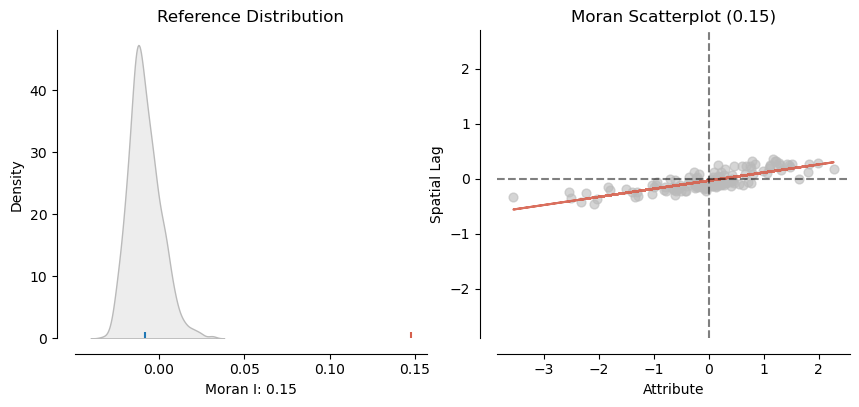

In [7]:
mi = esda.Moran(gdf["humedad_relativa"], w_dist20km)
plot_moran(mi)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

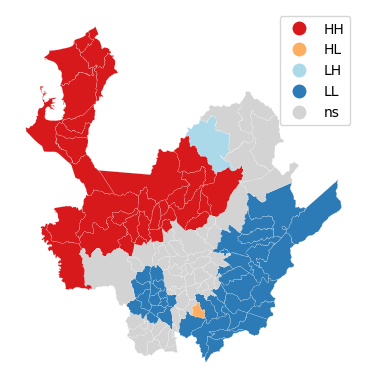

In [9]:
from splot.esda import lisa_cluster

lisa = esda.Moran_Local(gdf["humedad_relativa"], w_dist20km)
lisa_cluster(lisa, gdf)

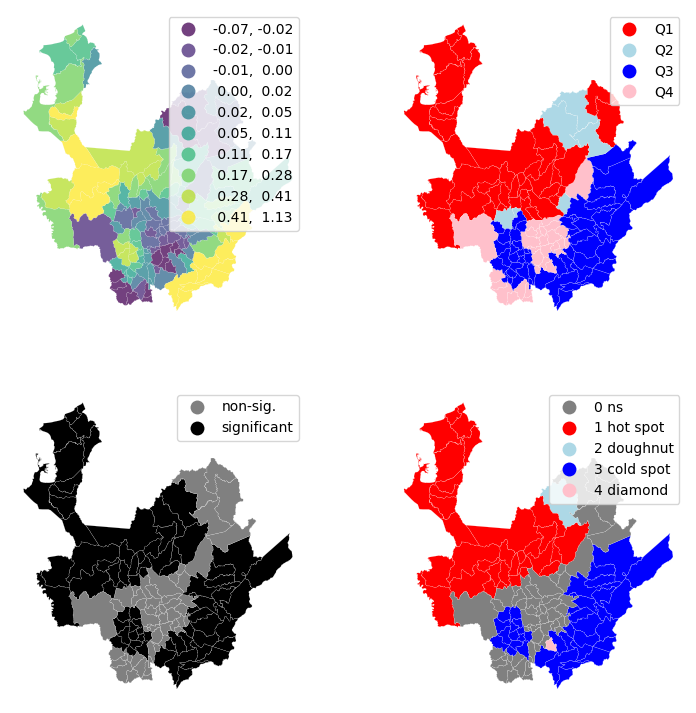

In [10]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

f, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
axs = axs.flatten()

gdf["Is"]=lisa.Is

# Subplot 1 #
ax = axs[0]
gdf.plot(column='Is', cmap='viridis', scheme='quantiles', k=10, edgecolor='white', linewidth=0.1, alpha=0.75, legend=True, ax=ax)
ax.set_aspect('equal')
ax.set_axis_off()

# Subplot 2 #
ax = axs[1]
q_labels = ['Q1', 'Q2', 'Q3', 'Q4']
labels = [q_labels[i-1] for i in lisa.q]
hmap = ListedColormap([ 'red', 'lightblue', 'blue', 'pink'])
gdf.assign(cl=labels).plot(column='cl', categorical=True,k=2, cmap=hmap, linewidth=0.1, ax=ax,edgecolor='white', legend=True)
ax.set_aspect('equal')
ax.set_axis_off()

# Subplot 3 #
ax = axs[2]
sig = 1 * (lisa.p_sim < 0.05)
hmap = ListedColormap(['grey','black'])
labels = ['non-sig.', 'significant'] 
labels = [labels[i] for i in sig]
gdf.assign(cl=labels).plot(column='cl', categorical=True,k=2, cmap=hmap, linewidth=0.1, ax=ax,edgecolor='white', legend=True)
ax.set_aspect('equal')
ax.set_axis_off()
                            
# Subplot 4 #
ax = axs[3]
hotspot = 1 * (sig * lisa.q==1)
coldspot = 3 * (sig * lisa.q==3)
doughnut = 2 * (sig * lisa.q==2)
diamond = 4 * (sig * lisa.q==4)
spots = hotspot + coldspot + doughnut + diamond
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]
hmap = ListedColormap([ 'grey', 'red', 'lightblue', 'blue', 'pink'])
gdf.assign(cl=labels).plot(column='cl', categorical=True,k=2, cmap=hmap, linewidth=0.1, ax=ax,edgecolor='white', legend=True)
ax.set_aspect('equal')
ax.set_axis_off()

plt.show()

In [ ]:
%pip install matplotlib-scalebar

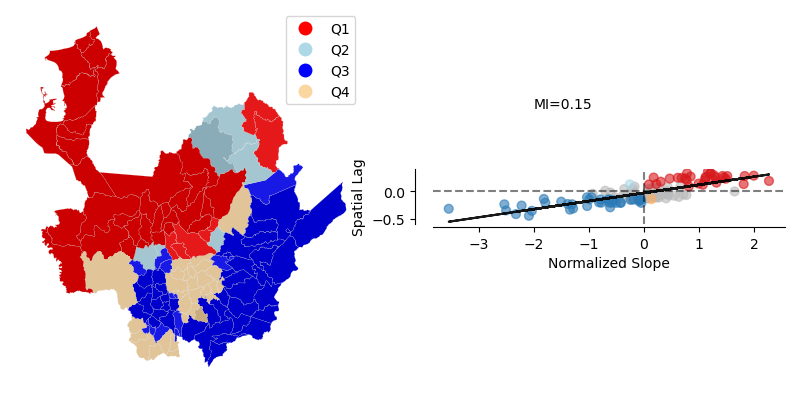

In [13]:
from matplotlib_scalebar.scalebar import ScaleBar
from splot.esda import moran_scatterplot


f, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,5))
axs = ax.flatten()

q_labels = ['Q1', 'Q2', 'Q3', 'Q4']
labels1 = [q_labels[i-1] for i in lisa.q]
hmap = ListedColormap([ 'red', 'lightblue', 'blue', '#FAD7A0'])
gdf.assign(cl=labels1).plot(column='cl', categorical=True,k=2, cmap=hmap, linewidth=0.1, ax=ax[0],edgecolor='white', legend=True)

sig = 1 * (lisa.p_sim < 0.05)
hmap = ListedColormap(['grey','black'])
labels2 = ['non-sig.', 'significant'] 
labels2 = [labels2[i] for i in sig]
gdf.assign(cl=labels2).plot(column='cl', categorical=True,k=2, cmap=hmap, linewidth=0.1, ax=ax[0],edgecolor='white', alpha=0.20)
ax[0].set_aspect('equal')
ax[0].set_axis_off()

moran_scatterplot(lisa, p=0.05,ax=ax[1])
ax[1].text(-2,1.5,f'MI={round(mi.I, 2)}')
ax[1].set_xlabel("Normalized Slope")
ax[1].set_title('');

(<Figure size 1500x400 with 3 Axes>,
 array([<Axes: title={'center': 'Moran Local Scatterplot'}, xlabel='Attribute', ylabel='Spatial Lag'>,
        <Axes: >, <Axes: >], dtype=object))

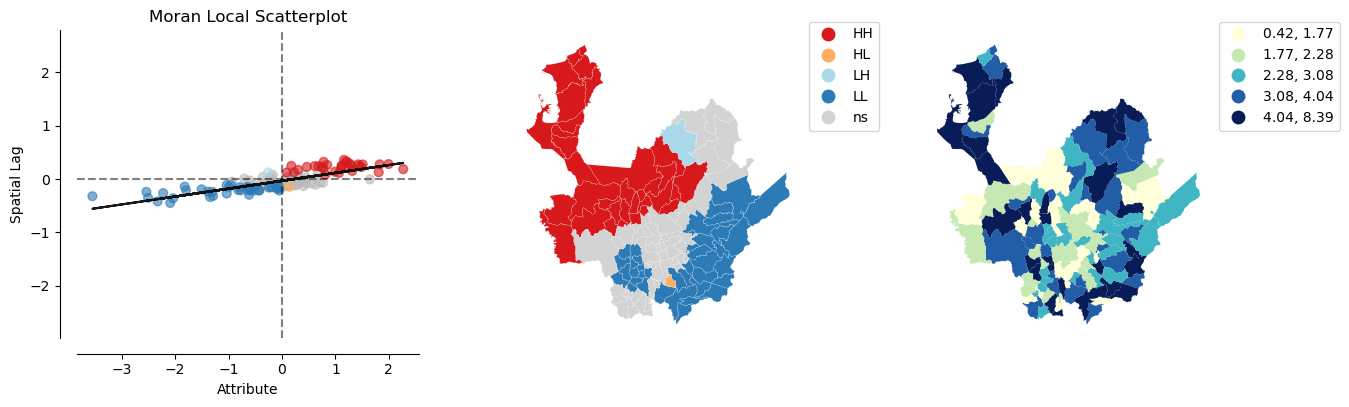

In [15]:
from splot.esda import plot_local_autocorrelation

plot_local_autocorrelation(lisa, gdf, 'cfr')

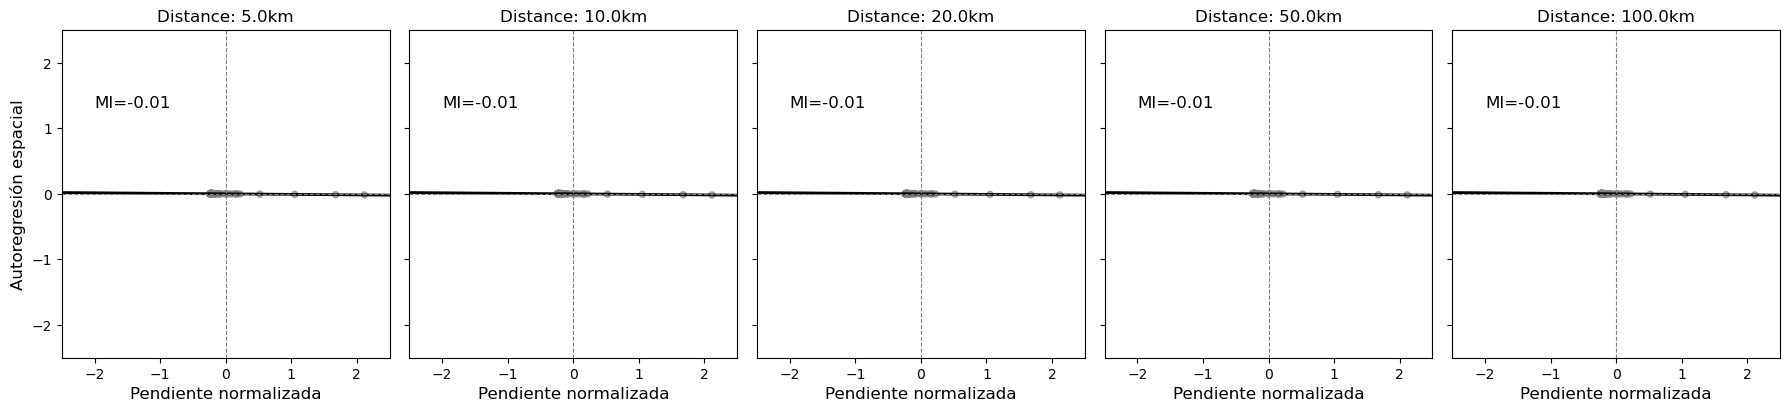

In [21]:
import numpy as np

distance = [5000, 10000, 20000, 50000, 100000]
variable = 'densidad'  # Specify the variable you want to use

# Create a single figure with subplots for different distances
f, ax = plt.subplots(nrows=1, ncols=len(distance), figsize=(18, 6), sharex=True, sharey=True) # Ajustado figsize y sharex/sharey para consistencia

for i, dx in enumerate(distance):
    # Create a DistanceBand weights matrix for the specified distance
    try:
        w_dist = DistanceBand.from_dataframe(gdf, dx, binary=True) # Binary=True es común para Moran I
        
        # Identify islands (disconnected components)
        islands = [k for k, v in w_dist.neighbors.items() if len(v) == 0]

        # Filter out islands from the GeoDataFrame
        if islands:
            cat_filtered = gdf.drop(index=islands)
            w_dist_filtered = DistanceBand.from_dataframe(cat_filtered, dx, binary=True)
        else:
            cat_filtered = gdf
            w_dist_filtered = w_dist
        
        # Normalizar la matriz de pesos por fila (standard row-standardization)
        w_dist_filtered.transform = 'R'

    except ValueError as e:
        print(f"Error al crear matriz de pesos para {dx/1000}km: {e}. Saltando este panel.")
        ax[i].set_title(f'Distance: {dx/1000}km (No data/neighbors)')
        ax[i].set_xlim([-2.5, 2.5])
        ax[i].set_ylim([-2.5, 2.5])
        ax[i].axvline(0, color='gray', linestyle='--')
        ax[i].axhline(0, color='gray', linestyle='--')
        continue # Skip to the next iteration

    # Asegurarse de que el número de observaciones sea suficiente
    if len(cat_filtered) < 2:
        print(f"No hay suficientes observaciones para {dx/1000}km después de filtrar islas. Saltando este panel.")
        ax[i].set_title(f'Distance: {dx/1000}km (Too few obs)')
        ax[i].set_xlim([-2.5, 2.5])
        ax[i].set_ylim([-2.5, 2.5])
        ax[i].axvline(0, color='gray', linestyle='--')
        ax[i].axhline(0, color='gray', linestyle='--')
        continue

    # --- CÁLCULOS PARA LA GRÁFICA DE DISPERSIÓN DE MORAN Y LA LÍNEA ---
    # 1. Estandarizar la variable (Z-scores)
    z = (cat_filtered[variable] - cat_filtered[variable].mean()) / cat_filtered[variable].std()
    
    # 2. Calcular el rezago espacial (WZ)
    w_z = w_dist_filtered.sparse @ z.values

    # 3. Calcular el Índice de Moran Global (MI)
    numerator = np.sum(z * w_z)
    denominator = np.sum(z**2)
    mi_global = numerator / denominator

    # 4. Calcular LISA para obtener los p-valores y determinar la significancia
    lisa = esda.Moran_Local(cat_filtered[variable], w_dist_filtered)
    
    # 5. Colorear los puntos basándose en LISA (cuadrante Y significancia p<=0.05)
    # Extraído de la lógica interna de splot.esda.moran_scatterplot
    p_threshold = 0.05 # Umbral de significancia
    
    # Asignar colores según los cuadrantes y la significancia
    point_colors = np.array(['gray'] * len(z), dtype=object) 
    
    # Cuadrante HH (Alto-Alto) - Rojo
    hh_idx = (z >= 0) & (w_z >= 0) & (lisa.p_sim <= p_threshold)
    point_colors[hh_idx] = 'red'

    # Cuadrante LL (Bajo-Bajo) - Azul Oscuro
    ll_idx = (z < 0) & (w_z < 0) & (lisa.p_sim <= p_threshold)
    point_colors[ll_idx] = 'darkblue'

    # Cuadrante HL (Alto-Bajo) - Naranja
    hl_idx = (z >= 0) & (w_z < 0) & (lisa.p_sim <= p_threshold)
    point_colors[hl_idx] = 'darkorange'

    # Cuadrante LH (Bajo-Alto) - Azul Claro
    lh_idx = (z < 0) & (w_z >= 0) & (lisa.p_sim <= p_threshold)
    point_colors[lh_idx] = 'lightskyblue'

    # Los puntos no significativos (grises) ya están asignados por defecto si no cumplen las condiciones anteriores.

    # --- 6. Graficar los puntos (manualmente) ---
    ax[i].scatter(z, w_z, s=20, c=point_colors, alpha=0.6)
    
    # --- 7. Dibujar la línea de regresión MANUALMENTE (la única línea negra) ---
    x_line = np.array([-2.5, 2.5]) 
    y_line = mi_global * x_line
    ax[i].plot(x_line, y_line, color='k', linestyle='-', linewidth=2)

    # --- El resto de tu código para etiquetas y formato ---
    ax[i].text(-2, 1.5, f'MI={mi_global:.2f}', fontsize=12, horizontalalignment='left', verticalalignment='top')
    ax[i].set_xlabel('Pendiente normalizada', fontsize=12)
    if i == 0:
        ax[i].set_ylabel("Autoregresión espacial", fontsize=12)
    else:
        ax[i].set_ylabel("")
    ax[i].set_title(f'Distance: {dx/1000}km')

    # Set consistent limits and aspect for the scatterplot
    ax[i].set_xlim([-2.5, 2.5])
    ax[i].set_ylim([-2.5, 2.5])
    ax[i].set_aspect('equal', adjustable='box') # CRUCIAL para una visualización correcta de la pendiente

    # Añadimos líneas de referencia
    ax[i].axvline(0, color='gray', linestyle='--', linewidth=0.8)
    ax[i].axhline(0, color='gray', linestyle='--', linewidth=0.8)

# Ajustar el layout y guardar la figura
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta el layout para que el título principal no se solape